## Data preprocessing

In [1]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,4]]
data.rename(columns={'low':'close'}, inplace=True)

from talib import RSI
data['rsi'] = RSI(data['close'])

data['price_shift'] = data['close'].shift(1)
data.dropna(axis=0, inplace=True)

data['price_up'] = data['close'] > data['price_shift']
data['rsi_up'] = data['rsi'] > 70
data['target'] = data['rsi_up'] & data['price_up']

In [2]:
data

timestamp    close        rsi  price_shift  price_up  rsi_up  target
14     1612814400  1722.77  69.909027      1701.83      True   False   False
15     1612818000  1701.14  65.086474      1722.77     False   False   False
16     1612821600  1719.79  67.188222      1701.14      True   False   False
17     1612825200  1755.61  70.821370      1719.79      True    True    True
18     1612832400  1739.90  67.301602      1755.61     False   False   False
...           ...      ...        ...          ...       ...     ...     ...
24354  1707336000  2438.64  79.375495      2418.66      True    True    True
24355  1707339600  2429.71  73.149791      2438.64     False    True   False
24356  1707343200  2424.75  69.871719      2429.71     False   False   False
24357  1707346800  2424.22  69.513250      2424.75     False   False   False
24358  1707350400  2433.89  72.305061      2424.22      True    True    True

[24345 rows x 7 columns]

## One side RSI>70 classifier

In [3]:
data_input = data.iloc[:, [1, 2]]
data_target = data.target

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_input, data_target, test_size=0.2, random_state=42, shuffle=False)

In [6]:
X_train, X_test

(         close        rsi
 14     1722.77  69.909027
 15     1701.14  65.086474
 16     1719.79  67.188222
 17     1755.61  70.821370
 18     1739.90  67.301602
 ...        ...        ...
 19485  1867.21  54.240309
 19486  1866.10  52.608147
 19487  1865.62  51.881115
 19488  1868.08  55.291249
 19489  1874.90  63.099030
 
 [19476 rows x 2 columns],
          close        rsi
 19490  1865.41  50.011171
 19491  1867.11  51.934471
 19492  1865.52  49.996932
 19493  1863.20  47.228256
 19494  1866.91  51.822786
 ...        ...        ...
 24354  2438.64  79.375495
 24355  2429.71  73.149791
 24356  2424.75  69.871719
 24357  2424.22  69.513250
 24358  2433.89  72.305061
 
 [4869 rows x 2 columns])

In [7]:
tree1 = DecisionTreeClassifier()

In [8]:
tree1.fit(X_train, y_train)

DecisionTreeClassifier()

In [9]:
y_pred = tree1.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9839802834257547


## Double side 30<RSI<70 classifier

In [11]:
data2 = pd.read_csv('data_sample_three_years.csv')

data2 = data2.iloc[:, [0,3]]
data2.rename(columns={'high':'close'}, inplace=True)

from talib import RSI
data2['rsi'] = RSI(data2['close'])

data2['price_shift_up'] = data2['close'].shift(1)
data2['price_shift_down'] = data2['close'].shift(-1)
data2.dropna(axis=0, inplace=True)

data2['price_up'] = data2['close'] > data2['price_shift_up']
data2['price_down'] = data2['close'] > data2['price_shift_down']
data2['rsi_up'] = data2['rsi'] > 70
data2['rsi_down'] = data2['rsi'] < 30

data2['target_1'] = data2['rsi_up'] & data2['price_up']
data2['target_2'] = data2['rsi_down'] & data2['price_down']

data2['target'] = data2['target_1'] | data2['target_2']

In [12]:
data2_input = data2.iloc[:, [1, 2]]
data2_target = data2.target

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data2_input, data2_target, test_size=0.2, random_state=42, shuffle=False)

tree2 = DecisionTreeClassifier()

In [14]:
tree2.fit(X_train, y_train)

DecisionTreeClassifier()

In [15]:
y_pred = tree2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.960156089546108


# Trying on validation data

In [16]:
data_valid = pd.read_csv('data_sample_new.csv')

In [17]:
data_valid = data_valid.iloc[:, [0,5]]

In [18]:
from talib import RSI
data_valid['rsi'] = RSI(data_valid['close'])
data_valid.dropna(axis=0, inplace=True)

In [19]:
data_valid = data_valid.iloc[:, [1,2]]

In [20]:
valid_pred = tree2.predict(data_valid)

In [21]:
valid_pred

array([False, False, False, ..., False, False, False])

## Export it pickling the tree2

In [22]:
import pickle

# Specify the file path where you want to save the pickled Q-matrix
file_path = 'tree2.pkl'

# Pickle the Q-matrix and save it to a file
with open(file_path, 'wb') as f:
    pickle.dump(tree2, f)

In [23]:
data_valid

close        rsi
14    2207.43  30.089374
15    2209.03  40.303959
16    2209.27  41.680433
17    2208.23  37.631163
18    2208.10  37.145378
...       ...        ...
8575  2274.95  50.189853
8576  2274.31  46.626386
8577  2275.36  52.575516
8578  2275.87  55.188188
8579  2276.04  56.057215

[8566 rows x 2 columns]

In [24]:
data_valid['price_shift_up'] = data_valid['close'].shift(1)
data_valid['price_shift_down'] = data_valid['close'].shift(-1)
#data_valid.dropna(axis=0, inplace=True)

data_valid['price_up'] = data_valid['close'] > data_valid['price_shift_up']
data_valid['price_down'] = data_valid['close'] > data_valid['price_shift_down']
data_valid['rsi_up'] = data_valid['rsi'] > 70
data_valid['rsi_down'] = data_valid['rsi'] < 30

data_valid['target_1'] = data_valid['rsi_up'] & data_valid['price_up']
data_valid['target_2'] = data_valid['rsi_down'] & data_valid['price_down']

data_valid['target'] = data_valid['target_1'] | data_valid['target_2']

In [25]:
data_valid

close        rsi  price_shift_up  price_shift_down  price_up  \
14    2207.43  30.089374             NaN           2209.03     False   
15    2209.03  40.303959         2207.43           2209.27      True   
16    2209.27  41.680433         2209.03           2208.23      True   
17    2208.23  37.631163         2209.27           2208.10     False   
18    2208.10  37.145378         2208.23           2208.76     False   
...       ...        ...             ...               ...       ...   
8575  2274.95  50.189853         2275.87           2274.31     False   
8576  2274.31  46.626386         2274.95           2275.36     False   
8577  2275.36  52.575516         2274.31           2275.87      True   
8578  2275.87  55.188188         2275.36           2276.04      True   
8579  2276.04  56.057215         2275.87               NaN      True   

      price_down  rsi_up  rsi_down  target_1  target_2  target  
14         False   False     False     False     False   False  
15         False   False     False     False     False   False  
16          True   False     False     False     False   False  
17          True   False     False     False     False   False  
18         False   False     False     False     False   False  
...          ...     ...       ...       ...       ...     ...  
8575        True   False     False     False     False   False  
8576       False   False     False     False     False   False  
8577       False   False     False     False     False   False  
8578       False   False     False     False     False   False  
8579       False   False     False     False     False   False  

[8566 rows x 11 columns]

In [26]:
data_valid['pred'] = valid_pred

In [27]:
data_valid

close        rsi  price_shift_up  price_shift_down  price_up  \
14    2207.43  30.089374             NaN           2209.03     False   
15    2209.03  40.303959         2207.43           2209.27      True   
16    2209.27  41.680433         2209.03           2208.23      True   
17    2208.23  37.631163         2209.27           2208.10     False   
18    2208.10  37.145378         2208.23           2208.76     False   
...       ...        ...             ...               ...       ...   
8575  2274.95  50.189853         2275.87           2274.31     False   
8576  2274.31  46.626386         2274.95           2275.36     False   
8577  2275.36  52.575516         2274.31           2275.87      True   
8578  2275.87  55.188188         2275.36           2276.04      True   
8579  2276.04  56.057215         2275.87               NaN      True   

      price_down  rsi_up  rsi_down  target_1  target_2  target   pred  
14         False   False     False     False     False   False  False  
15         False   False     False     False     False   False  False  
16          True   False     False     False     False   False  False  
17          True   False     False     False     False   False  False  
18         False   False     False     False     False   False  False  
...          ...     ...       ...       ...       ...     ...    ...  
8575        True   False     False     False     False   False  False  
8576       False   False     False     False     False   False  False  
8577       False   False     False     False     False   False  False  
8578       False   False     False     False     False   False  False  
8579       False   False     False     False     False   False  False  

[8566 rows x 12 columns]

In [28]:
data_valid = data_valid.iloc[:, [0,1,10,11]]

In [29]:
data_valid.to_excel('data_valid.xlsx', index=False)

In [30]:
data_valid

close        rsi  target   pred
14    2207.43  30.089374   False  False
15    2209.03  40.303959   False  False
16    2209.27  41.680433   False  False
17    2208.23  37.631163   False  False
18    2208.10  37.145378   False  False
...       ...        ...     ...    ...
8575  2274.95  50.189853   False  False
8576  2274.31  46.626386   False  False
8577  2275.36  52.575516   False  False
8578  2275.87  55.188188   False  False
8579  2276.04  56.057215   False  False

[8566 rows x 4 columns]

In [31]:
accuracy = accuracy_score(data_valid['target'], valid_pred)

In [32]:
accuracy

0.9726826990427271

## draw tree graph

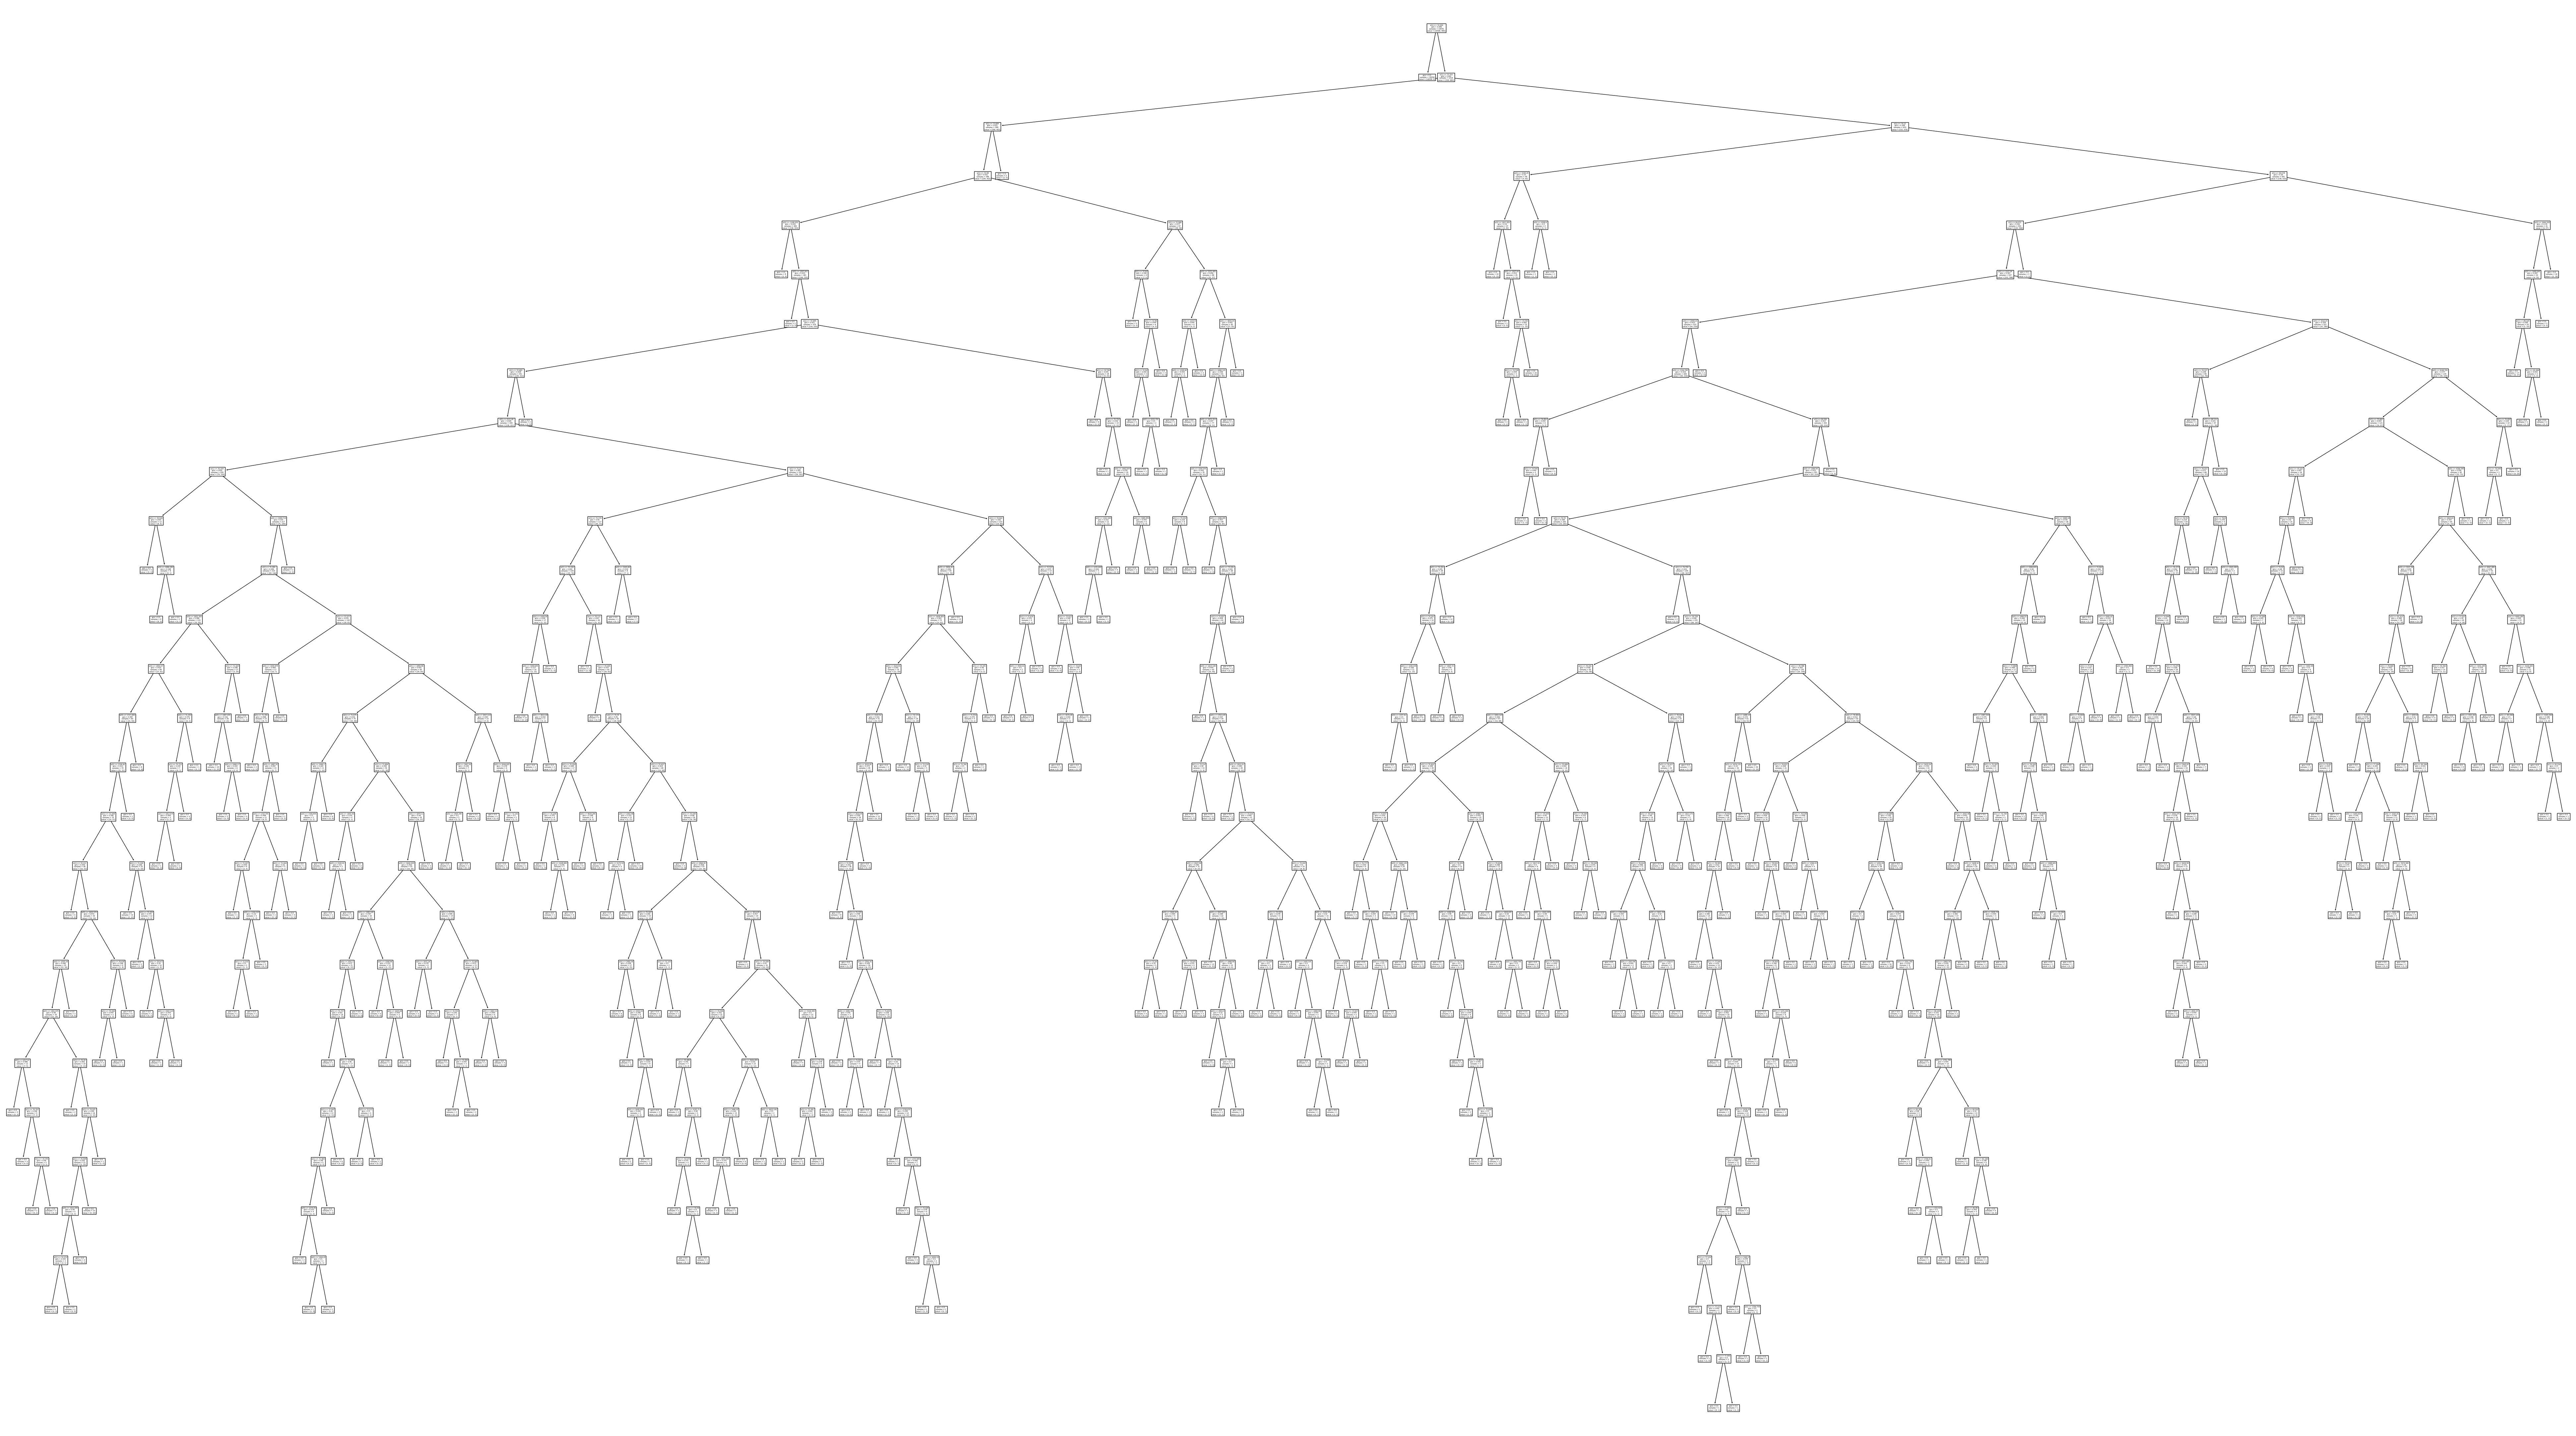

In [37]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(100, 56))
tree.plot_tree(tree1)
#plt.savefig('my_tree.png')
plt.show()

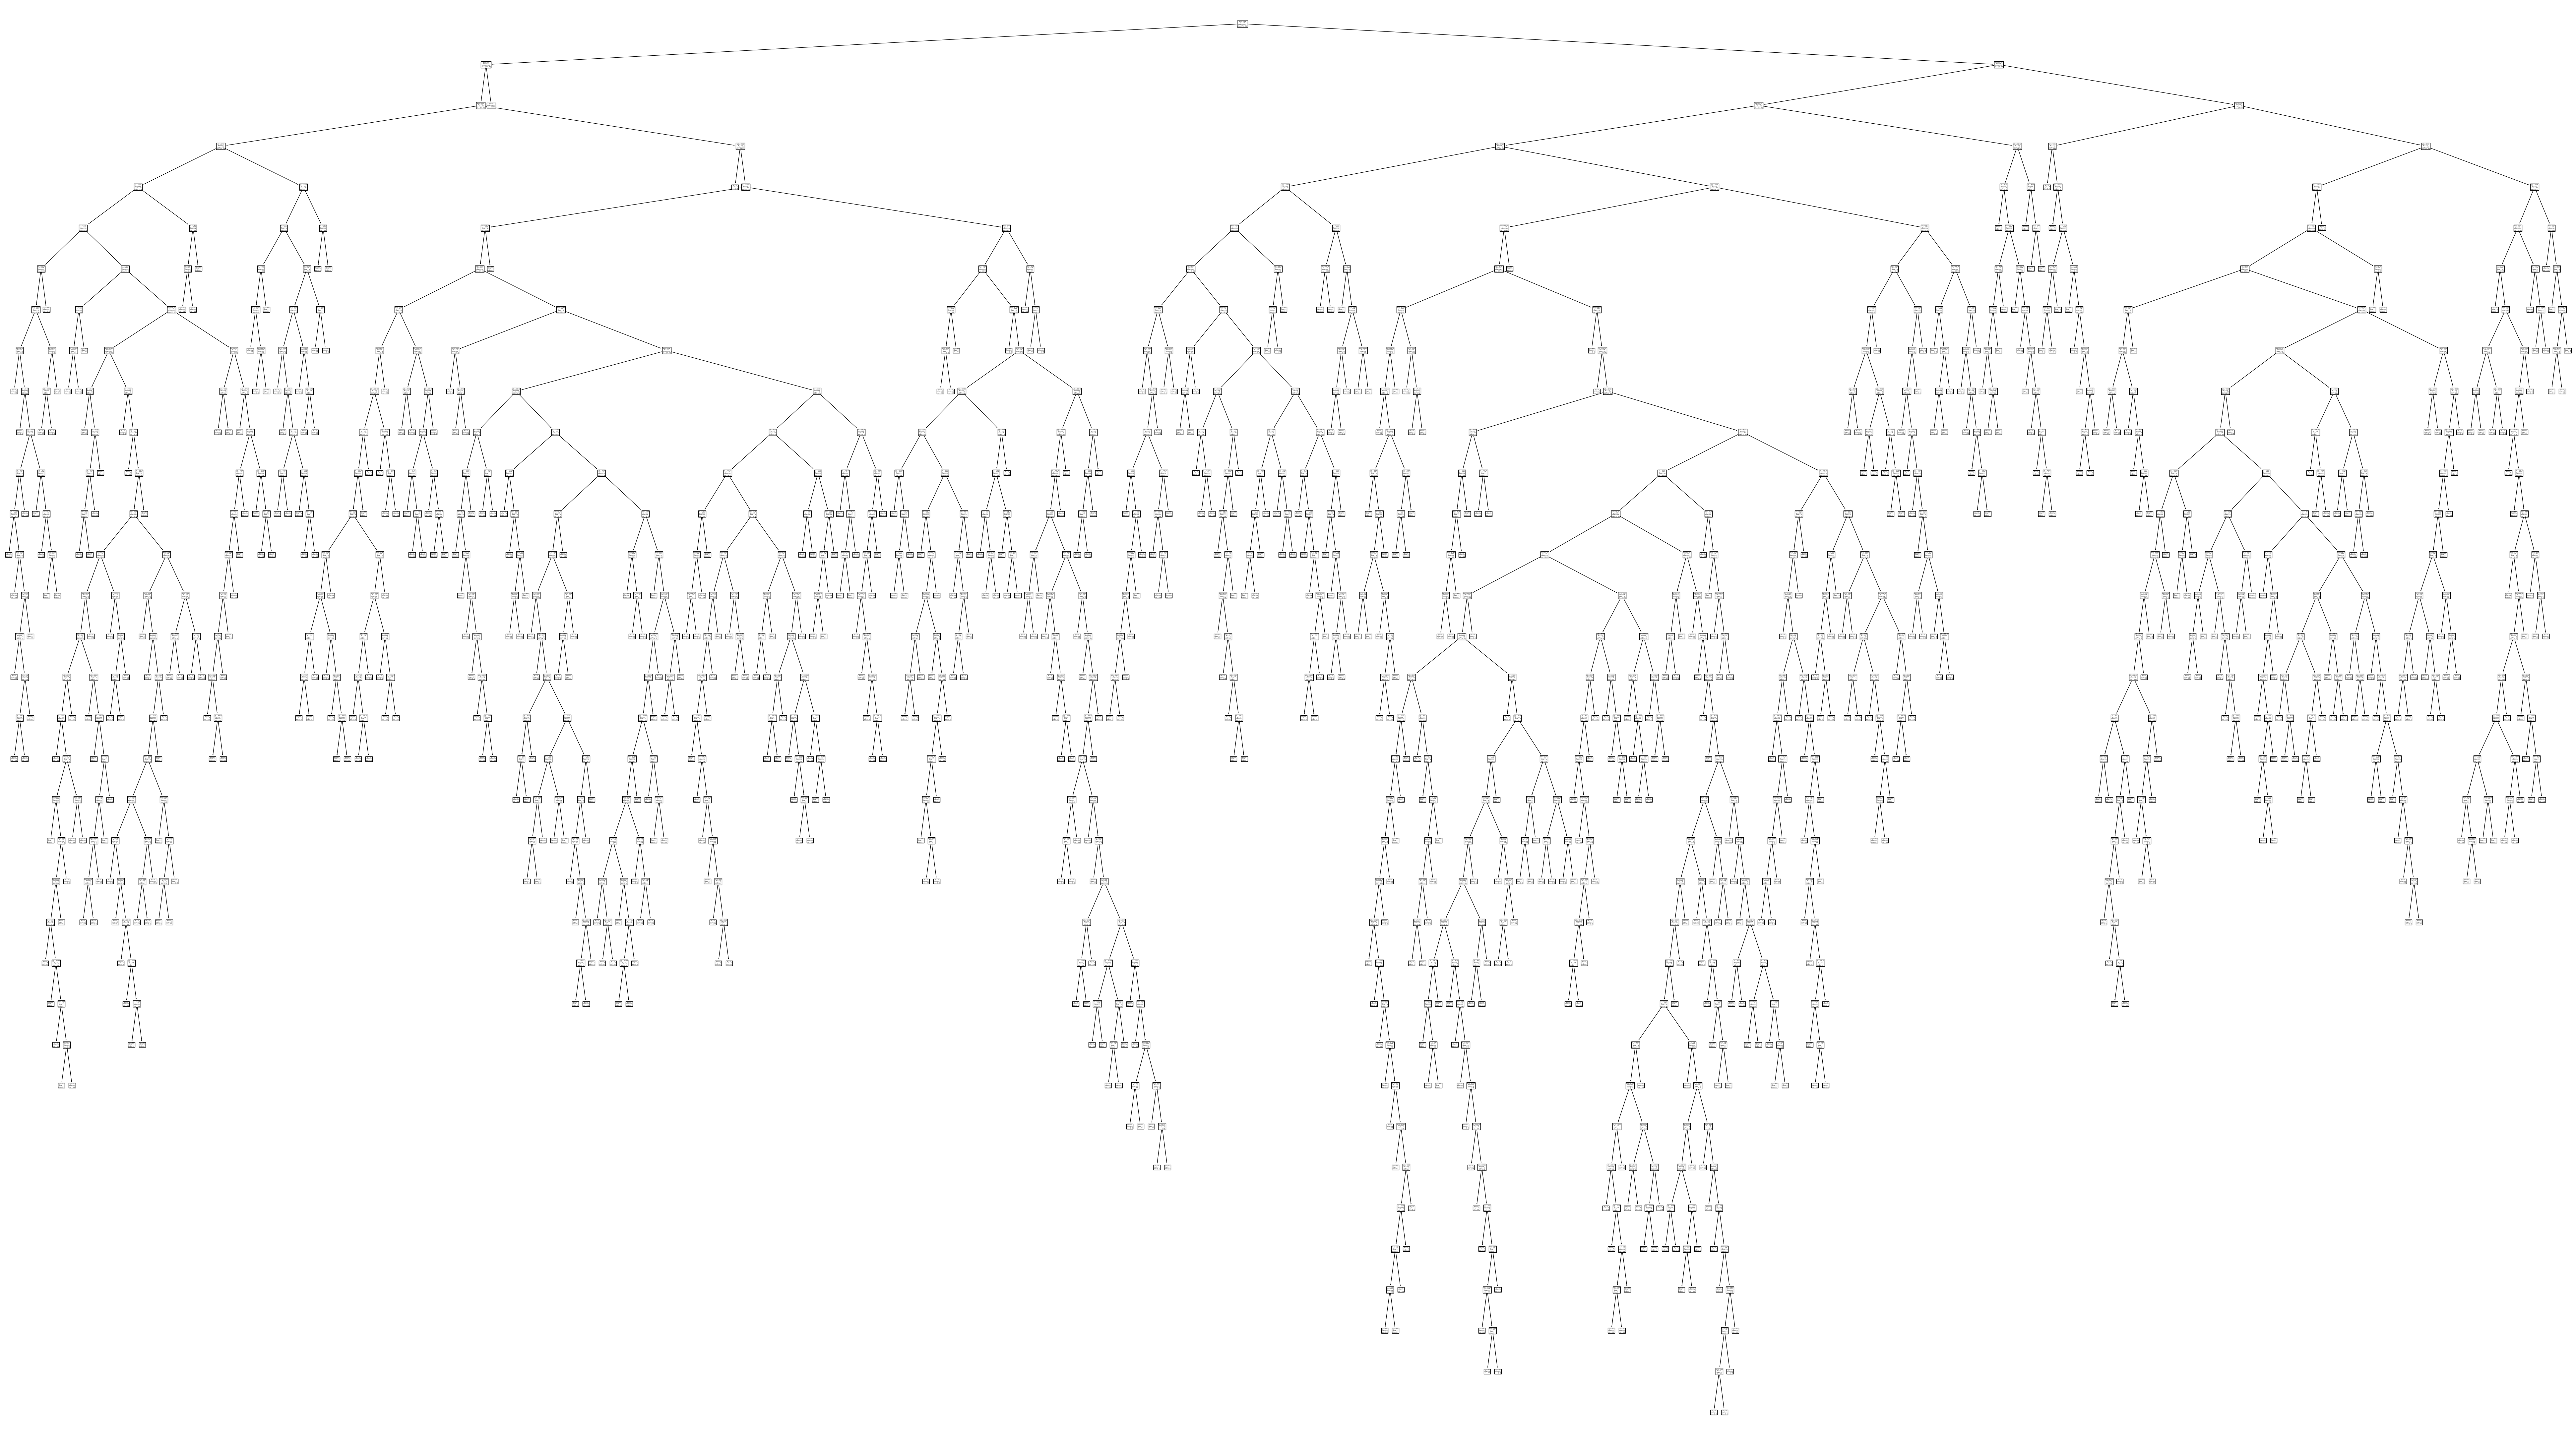

In [38]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(100, 56))
tree.plot_tree(tree2)
#plt.savefig('my_tree.png')
plt.show()